# Ausreißer in Zeitreihen verlässlich erkennen

Rechnungen zum Artikel.

Das Jupyter-Notebook repoduziert alle Grafiken des Artikels. Darüber laden weitere Demodaten ein, mit vielen freien Parameter zu experimentieren.

Während STL + LOF (siehe unten) bei Zeitreihen mit wechselhafter Saisonalität und großen Datensätzen gut abschneiden -- siehe Artikel --, liefert HDBSCAN bei stochastischen Funktionen wie einem Random Walk und kleinen Datensätzen mit geringer Saisonalität gute Ergebnisse, meist auch besser als das Spezialverfahren LOF. Nachteil bei *HDBSCAN* ist das Trimmen der Hyperparameter bei unbekanntem Anteil von Ausreißern.

Demodatensätze mit bekanntem Anteil an Ausreißern durchlaufen verschiedene Testfunktionen. Diese schreiben ihre Ergebnisse in einen Textstring, der am Ende des Durchlaufs die Ergebnisse protokolliert.

## Daten erzeugen

In [1]:
%reset -f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Optionen: 

* Wahl der Datenquelle: ['fakedata', 'oneweek', 'fourmonths', 'sixmonths', 'fullyear', 'random_w']
* Wahl des Ausreißeranteils: `outlier_share`
* Rauschen hinzufügen: `choose_noisy`

Der Artikel untersucht den Datensatz aus einer PV-Energieeinspeisung aus dem Jahr 2023 (`chose_opt=4`).


In [2]:
options_ds = ['fakedata', 'oneweek', 'fourmonths', 'sixmonths', 'fullyear', 'random_w']
choose_noisy = False # noisy data?
choose_opt = 4
outlier_share =  0.1 # 10% outliers

In [3]:
def add_noisycol(dgn, share=0.1, noiselevel=1, seed=42):
    """
    in: 
      dgn: one column dataframe
      noiselevel: the larger the noisier
      share: share of points replaced by outliers
      seed: random seed
    out: dataframe + 4 columns. 
        0: (s) original data
        1: so: data + outliers
        2: sn: noisy data; 
        3: sno: noisy data + outliers
        4: ob: true if outlier
        5: indx: index 
    outliers are within min=0 and max
    vers 0.3
    """
    # noise data
    rng = np.random.default_rng(seed)
    noise = rng.normal(0,dgn.std()/10*noiselevel, len(dgn))
    # index and values for outliers
    nsharei = int(share * len(dgn))
    outliersi = rng.choice(len(dgn), nsharei, replace=False)
    outliersvals = rng.uniform(0, dgn.iloc[:,0].max() , nsharei)
    
    # 1 (so): source + outliers
    dgn['so'] = dgn.iloc[:,0] 
    dgn.iloc[outliersi,1]= outliersvals
    # 2 (sn) source + noise
    dgn['sn'] = dgn.iloc[:,0]+noise
    # 3 (sno): source + noise + outliers
    dgn['sno'] = dgn.iloc[:,2] 
    dgn.iloc[outliersi,3]= outliersvals
    # 4 (ob): outlier boolean
    dgn['ob'] = False
    dgn.iloc[outliersi,-1]=True
    # index
    dgn['indx'] = np.arange(len(dgn))
    return dgn
            

In [4]:
def fakedata():
    """
    Simulate electric power data for one week, one value per 15 minutes
    """
    ndays = 7 # duration in days
    pointsph = 4 # points per hour; if changed, change " freq='10min' " below as well.
    ppd = np.arange(0,pointsph*24) # points per day
    dpower = ppd*0. # power during day
    dpower[6*pointsph:18*pointsph] = np.cos(ppd[6*pointsph:18*pointsph]/(pointsph*24)*np.pi*2)**2 * 100
    
    tpower = np.concatenate([dpower]*ndays)
    date = pd.date_range(freq='15min', start='2024-01-01', periods=len(tpower)).astype(str).to_list()
    df = pd.DataFrame(dict(Ist=tpower, date=date))
    df['Ist'] = df.Ist * (0.8 * np.sin(df.index/len(df)*np.pi)+0.2)
    df = df.set_index(['date'])
    df.index = pd.to_datetime(df.index)
    return df

In [5]:
def fakedata_rw(periods = 672, seed = 43):
    """
    create random walk data
    return dataframe of size periods

    """
    rng2 = np.random.default_rng(seed)
    df = pd.DataFrame()
    df.index =  pd.date_range(freq='15min', start='2024-01-01', periods=periods)
    df['Ist'] = ((rng2.random(periods)-0.5)*2).cumsum()
    return df

In [6]:
def truedata_pv_2018():
    """
    True dataset photovoltaik power supply
    """
    # protect Datum format
    dtype_dict = {'Datum': 'str', 'Uhrzeit':'str', 
                  '8:00 Uhr Prognose [MW]': 'float64',
                  'Online Hochrechnung [MW]': 'float64'}
    fn = 'data/pv_einspeisung-01.01.2018.zip'
    
    df = pd.read_csv(fn, thousands='.', decimal=',', sep=";", dtype=dtype_dict)
    df.columns = ['Datum', 'Uhrzeit', 'Prognose', 'Ist']
    df['Date'] = df.Datum + 'T' + df.Uhrzeit.str[:5]
    df.index = pd.to_datetime(df.Date, format="%d.%m.%YT%H:%M")
    df = df[['Ist']].copy()
    df = df.resample('15min').mean()
    print('isnull: ', df.isnull().sum())
    df = df.interpolate()
    print('isnull: ', df.isnull().sum())
    return df
        
    

In [7]:
df = truedata_pv_2018()
df.info()

isnull:  Ist    791
dtype: int64
isnull:  Ist    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 242592 entries, 2018-01-01 00:00:00 to 2024-12-01 23:45:00
Freq: 15min
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Ist     242592 non-null  float64
dtypes: float64(1)
memory usage: 3.7 MB


Auswahl eines Datensatzes:

In [8]:
option_sel = options_ds[choose_opt]
print(f'Data set: {option_sel}, Noisy: {choose_noisy}')

match option_sel:
    case 'fakedata':
        ## one week fake data
        dg = fakedata()
    case 'oneweek':
        ## one week orignal data
        dg = df.loc['2023-06-01':'2023-06-08',:].copy()
    case 'fourmonths':
        ## four months
        dg = df.loc['2023-05-01':'2023-08-31',:].copy()
    case 'sixmonths':
        ## six months
        dg = df.loc['2023-04-01':'2023-09-30',:].copy()
    case 'fullyear':
        ## full year original data 
        dg = df.loc['2023-01-01':'2023-12-31',:].copy()
        # dg.to_csv('photovoltaicpower.csv')
    case 'random_w':
        ## random walk
        dg = fakedata_rw()



Data set: fullyear, Noisy: False


<Axes: xlabel='Date'>

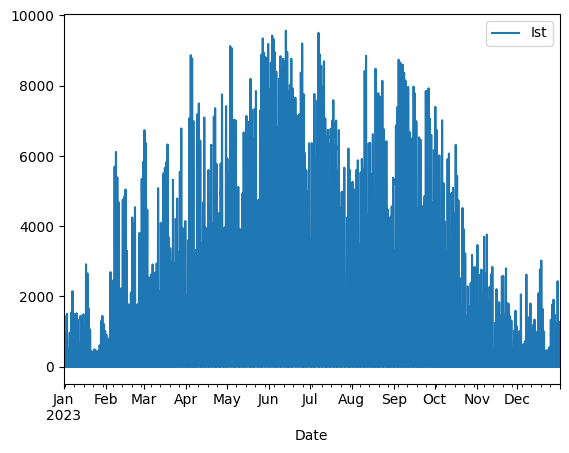

In [9]:
dg.plot()

In [10]:
protocol = []
protocol.append(f'Data set: {option_sel}, Noisy: {choose_noisy}, Outlier share: {outlier_share}\n')
protocol

['Data set: fullyear, Noisy: False, Outlier share: 0.1\n']

In [11]:
dgn = add_noisycol(dg, share=outlier_share, noiselevel=1, seed=42) #share=0.01) # share=0.1

## Hilfsfunktionen

In [12]:
def checkf(dgn2):
    """
    in: dataframe; columns: Ist, so, sn, sno, ob, indx, hdbl
        hdbl: result of hdbscan. -1:  outlierS
    positive: outlier
    true/false positive/negative
    """
    global option_sel, choose_noisy
    
    number_outl = dgn.ob.sum()
    tp = dgn2.query("ob==True & hdbl==-1").hdbl.count() # true positive
    fn = dgn2.query("ob==True & hdbl!=-1").hdbl.count() # false negative
    fp = dgn2.query("ob==False & hdbl==-1").hdbl.count() # false positive

    return (f'DS: {option_sel} outl {number_outl}, noisy: {choose_noisy}; tp, fp: ({tp}, {fp}) '
            f'{int(tp/number_outl*100)}, {int(fp/number_outl*100)} %')

In [13]:
def check(dgn2):
    """
    in: dataframe; columns: Ist, so, sn, sno, ob, indx, hdbl
        hdbl: result of hdbscan (-1 if outliers)
    positive: outlier
    true/false positive/negative
    """
    global option_sel, choose_noisy
    
    number_outl = dgn.ob.sum()
    tp = dgn2.query("ob==True & hdbl==-1").hdbl.count() # true positive
    fn = dgn2.query("ob==True & hdbl!=-1").hdbl.count() # false negative
    fp = dgn2.query("ob==False & hdbl==-1").hdbl.count() # false positive
    return (f'Result: Outliers {number_outl}, tp, fp: ({tp}, {fp}) '
            f'in percent: {int(tp/number_outl*100)}, {int(fp/number_outl*100)} %')

In [14]:
def plotresult(dgn2):
    """
    plot result; 
    compare so with Ist and mark tp, fn, fp outliers
    """
    fig,ax = plt.subplots(figsize=(8,6), dpi=120)
    dgn2.query("ob==True & hdbl==-1").so.plot(style='.', label='tp', ax=ax)
    dgn2.query("ob==True & hdbl!=-1").so.plot(style='X', label='fn',  markersize=7, ax=ax)
    dgn2.query("ob==False & hdbl==-1").so.plot(style='.', label='fp', markersize=20, ax=ax)
    #dgn2.Ist.plot(label='Ist', style='.' , ax=ax)
    # orig without outiers:
    if len(dgn2)<1000: 
        dgn2.query("ob==False").Ist.plot(label='Orig', style='.', markersize=2, ax=ax)
    else:
        dgn2.query("ob==False").Ist.plot(label='Orig', lw=1, markersize=2, ax=ax)
    ax.legend()
    plt.show()
    return None

Originaldaten

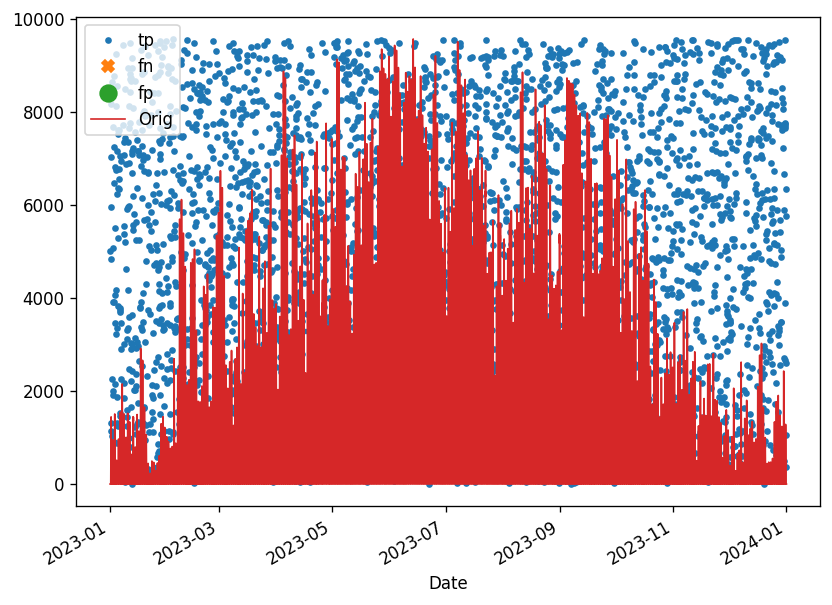

In [15]:
dginput = dgn.copy()
dginput['hdbl'] = dginput.ob * -1
plotresult(dginput)

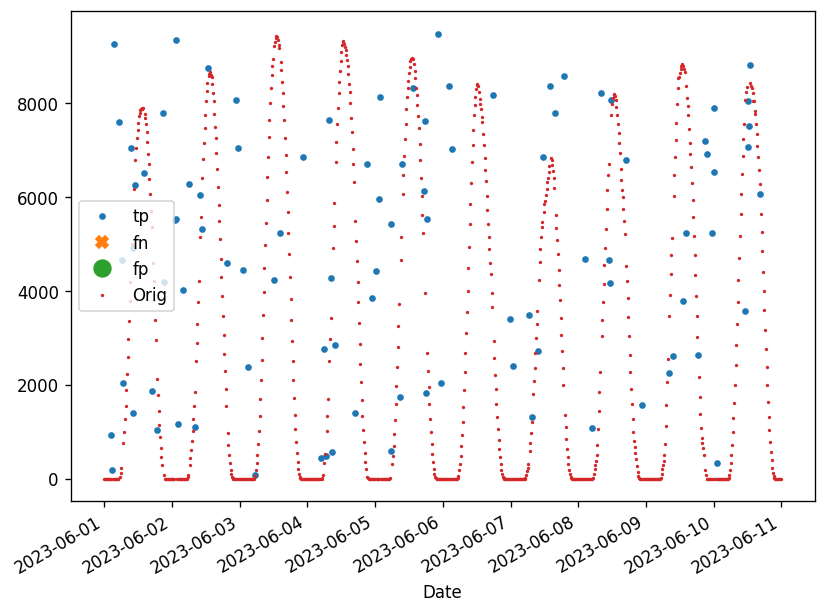

In [16]:
try:
    plotresult(dginput.loc['2023-06-01':'2023-06-10',:])
except:
    print('wrong time interval')

## HDBSCAN

Drei Parameter

* scaling=1000: Hier: x 0..700; y: 0..9'000; y-> y/scaling
* min_cluster_size=50; wenn zu groß, werden Kurventeile zu Außenseitern
* min_samples=6 und scaling=1000: sehr empfindlich; bei 4 verliert man ein Kurvenelement; bei 7 werden alle Punkte zu Ausreißern. Bei scaling=10'000 deutlich robuster

In [17]:
from sklearn.cluster import HDBSCAN

In [18]:
dgn.head(2)

,Ist,so,sn,sno,ob,indx
Date,,,,,,
2023-01-01 00:00:00,0.0,0.0,66.529407,66.529407,False,0
2023-01-01 00:15:00,0.0,0.0,-227.061528,-227.061528,False,1


Die Korrektur: len(dgn) -> len(dgn)-1 hat keine Auswirkungen auf die Ergebnisse.

In [19]:
dgn2 = dgn.copy()

if choose_noisy:
    # noisy + outlier: sno
    Xs = dgn.iloc[:,[3,5]]
    autoscale = (dgn.iloc[:,3] - dgn.iloc[:,3].shift(1)).abs().sum() / (len(dgn)-1)
else:
    # outlier: so
    Xs = dgn.iloc[:,[1,5]]
    autoscale = (dgn.iloc[:,1] - dgn.iloc[:,1].shift(1)).abs().sum() / (len(dgn)-1)

In [20]:
X = Xs.copy()

scaling, mc, ms = 1 * autoscale, 70, 5 

In [21]:
X.iloc[:,0] = X.iloc[:,0]/scaling

In [22]:
X.head(2)

,so,indx
Date,,
2023-01-01 00:00:00,0.0,0
2023-01-01 00:15:00,0.0,1


In [23]:
hdb = HDBSCAN(min_cluster_size=mc, min_samples=ms)
hdb.fit(X)

HDBSCAN(min_cluster_size=70, min_samples=5)

(array([2.4140e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.1000e+01, 2.6000e+01, 1.7000e+02, 4.5700e+02, 3.1912e+04]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

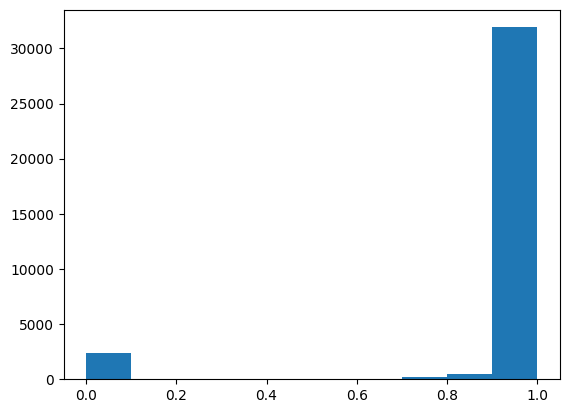

In [24]:
plt.hist(hdb.probabilities_)

In [25]:
#dgn2 = dgn.copy()
dgn2['hdbl'] = hdb.labels_
dgn2['prob'] = hdb.probabilities_

Positiv: Ausreißer; Negativ: kein Ausreißer.

Falsch Positiv: Werte, die fälschlich als Außenseiter deklariert werden.

`probabilities_`: 0 für Ausreißer; 1 für sichere Zuordnung.
Durch einen Schwellwert steigt die Zahl der Außreißer, nicht aber der fp Werte.

In [26]:
print(check(dgn2))

Result: Outliers 3504, tp, fp: (2214, 200) in percent: 63, 5 %


In [27]:
protocol.append('\nHDBSCAN ; scaling, n * autoscale, mc, ms\n')
protocol.append(f'{scaling}, {scaling/autoscale}, {mc}, {ms}: ')
protocol.append(check(dgn2))

In [28]:
print(''.join(protocol))

Data set: fullyear, Noisy: False, Outlier share: 0.1

HDBSCAN ; scaling, n * autoscale, mc, ms
855.2441132348008, 1.0, 70, 5: Result: Outliers 3504, tp, fp: (2214, 200) in percent: 63, 5 %


Über *prob* keine Möglichkeit, fp zu erkennen. Für alle erkannten Ausreißer (ie *htbl==-1*) ist *prob=0*.

Lediglich die Zahl der fn lässt sich erhöhen: wenn *prob<1* und *hdbl!=-1* könnten Wackelkandidaten aus den Clustern herausgeworfen werden und zu einem Ausreißer werden.

In [29]:
dgn2.head(2)

,Ist,so,sn,sno,ob,indx,hdbl,prob
Date,,,,,,,,
2023-01-01 00:00:00,0.0,0.0,66.529407,66.529407,False,0,-1,0.000000
2023-01-01 00:15:00,0.0,0.0,-227.061528,-227.061528,False,1,60,0.995541


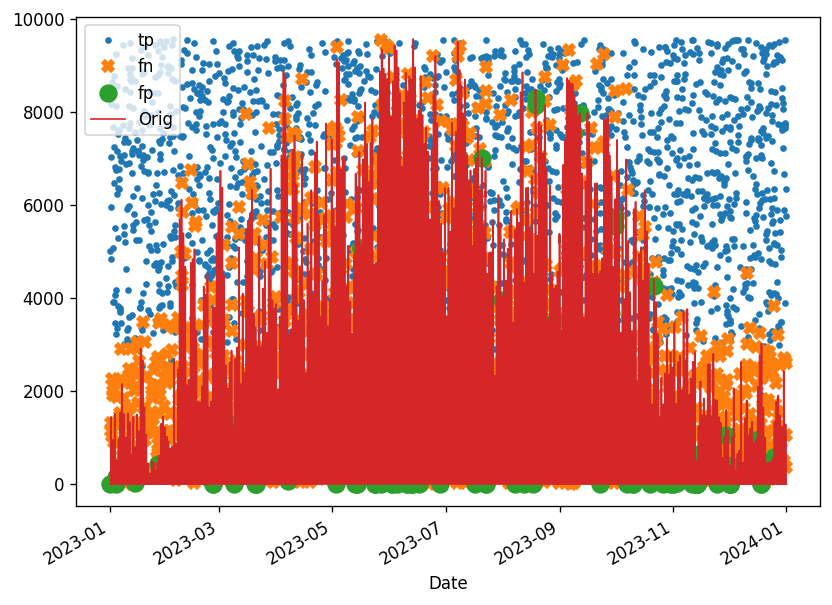

In [30]:
plotresult(dgn2)

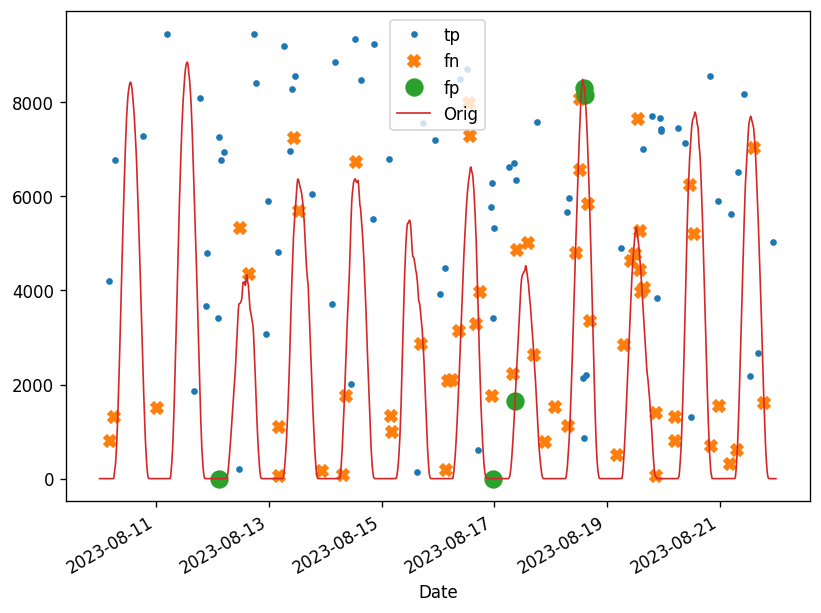

In [31]:
try:
    plotresult(dgn2.loc['2023-08-10':'2023-08-21',:])
except:
    print('wrong time interval')

## Local Outlier Factor (LOF)


In [32]:
from sklearn.neighbors import LocalOutlierFactor

In [33]:
dgn3 = dgn.copy()

if choose_noisy:
    # noisy + outlier: sno
    Xs = dgn.iloc[:,[3,5]]
    autoscale = (dgn.iloc[:,3] - dgn.iloc[:,3].shift(1)).abs().sum() / len(dgn)
else:
    # outlier: so
    Xs = dgn.iloc[:,[1,5]]
    autoscale = (dgn.iloc[:,1] - dgn.iloc[:,1].shift(1)).abs().sum() / len(dgn)

In [34]:
X = Xs.copy()

scaling, nn, cont = 0.5 * autoscale, 6, 'auto' # outlier share 10%

X.iloc[:,0] = X.iloc[:,0]/scaling

In [35]:
clf = LocalOutlierFactor(n_neighbors=nn, contamination=cont)  # 16 / 15

In [36]:
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

In [37]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [38]:
dgn3['hdbl'] = y_pred

In [39]:
print(check(dgn3))

Result: Outliers 3504, tp, fp: (2144, 0) in percent: 61, 0 %


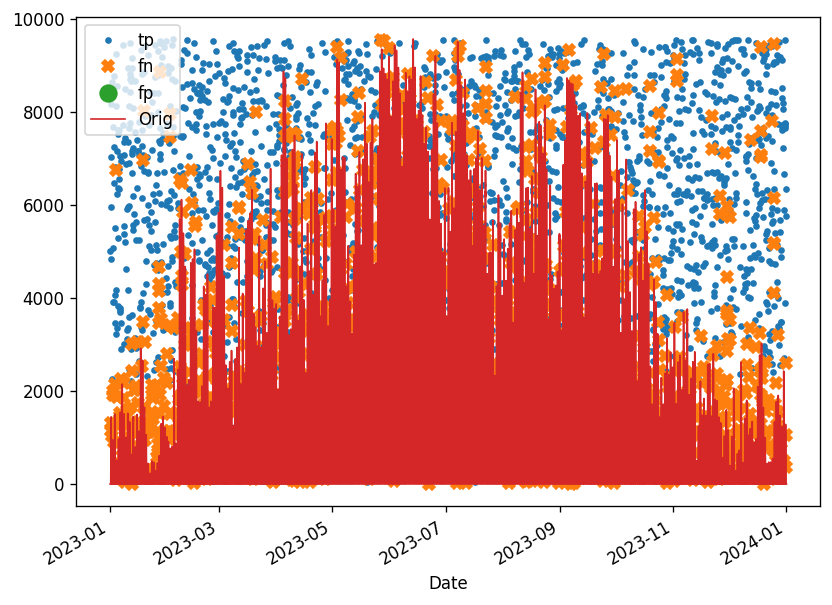

In [40]:
plotresult(dgn3)

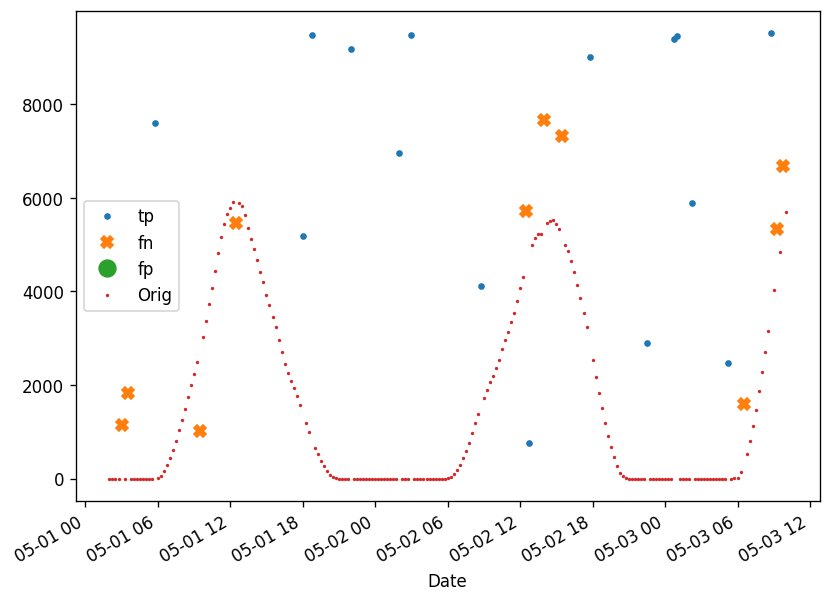

In [41]:
try:
    plotresult(dgn3.loc["2023-05-01 02:00":"2023-05-03 10:00",:])
except:
    print('wrong time interval')

In [42]:
protocol.append('\nLOF\n')
protocol.append(f'{scaling}, {scaling/autoscale}, {nn},{cont}: ')
protocol.append(check(dgn3))

## Isolation Forest

In [43]:
from sklearn.ensemble import IsolationForest

In [44]:
dgn4 = dgn.copy()

if choose_noisy:
    # noisy + outlier: sno
    Xs = dgn.iloc[:,[3,5]]
    autoscale = (dgn.iloc[:,3] - dgn.iloc[:,3].shift(1)).abs().sum() / len(dgn)
else:
    # outlier: so
    Xs = dgn.iloc[:,[1,5]]
    autoscale = (dgn.iloc[:,1] - dgn.iloc[:,1].shift(1)).abs().sum() / len(dgn)

In [45]:
X = Xs.copy()

#scaling, ne, cont = 50, 3000, 0.005
scaling, ne, cont = autoscale, 30, 'auto'

X.iloc[:,0] = X.iloc[:,0]/scaling

In [46]:
clf = IsolationForest(n_estimators=ne, contamination=cont)
clf.fit(X)

y_pred = clf.predict(X)

In [47]:

dgn4['hdbl'] = y_pred

In [48]:
print(check(dgn4))

Result: Outliers 3504, tp, fp: (3018, 11988) in percent: 86, 342 %


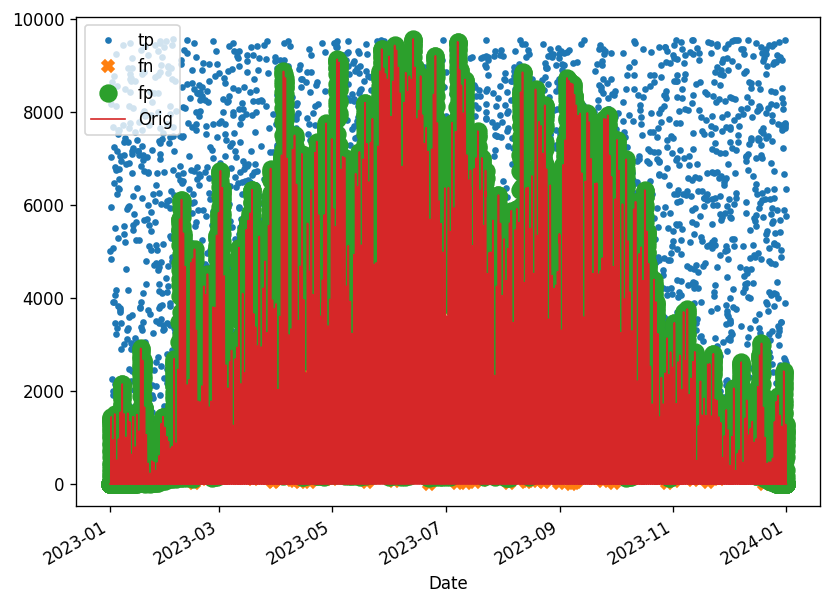

In [49]:
plotresult(dgn4)

In [50]:
protocol.append('\nIsolation Forest\n')
protocol.append(f'{scaling}, {scaling/autoscale}, {ne}, {cont}: ')
protocol.append(check(dgn4))

## STL


Glättungsparameter *seasonal*: `optional`

Ungerade Zahl, typischerweise >= 7.

In [51]:
from statsmodels.tsa.seasonal import STL

In [52]:
dgn5 = dgn.copy()

if choose_noisy:
    # noisy + outlier: sno
    #Xs = dgn.iloc[:,[3,5]]
    dgx = dgn.iloc[:,[3]].copy()
else:
    # outlier: so
    #Xs = dgn.iloc[:,[1,5]]
    dgx = dgn.iloc[:,[1]].copy()

In [53]:
# bug requires freq defined manually ("freq MIN not understood"):
# Frequency: every day; measurements every 15 minutes; peroid = minutes of day / 15 min

period = int(24*60/15)

In [54]:
# seasonal smoothing improves result
stl = STL(dgx, period=period, seasonal=int(period/2)*2 + 1) 

In [55]:
stlr = stl.fit()
dgx['residual'] = stlr.resid
dgx['Z-Score'] = np.abs((dgx['residual'] - dgx['residual'].mean()) / dgx['residual'].std())

In [56]:
zscore = 3 * dgx['Z-Score'].mean()

In [57]:
dgn5['hdbl'] = ( dgx['Z-Score'] > zscore ) * -1

In [58]:
print(check(dgn5))

Result: Outliers 3504, tp, fp: (2052, 8) in percent: 58, 0 %


In [59]:
protocol.append('\nSTL , zscore\n')
protocol.append(f'zscore {zscore} ')
protocol.append(check(dgn5))

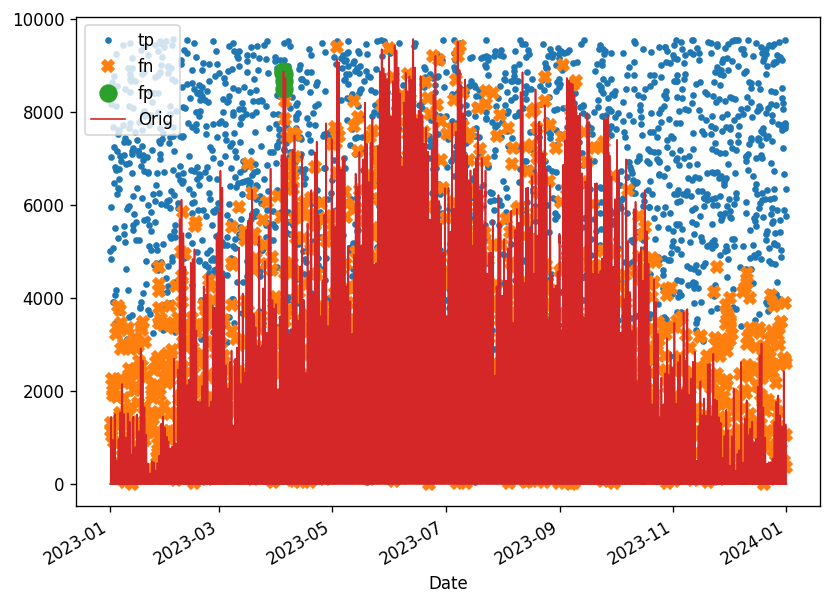

In [60]:
plotresult(dgn5)

In [61]:
#plotresult(dgn5.iloc[100:200,:])
dgn5.shape

(35040, 7)

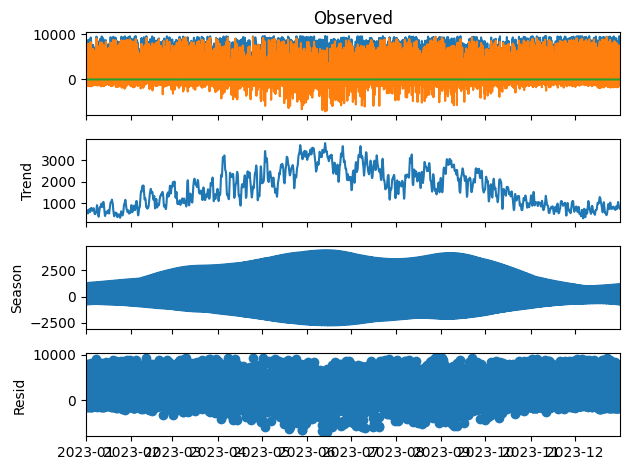

In [62]:
stlr.plot()
plt.show()

<Axes: xlabel='Date'>

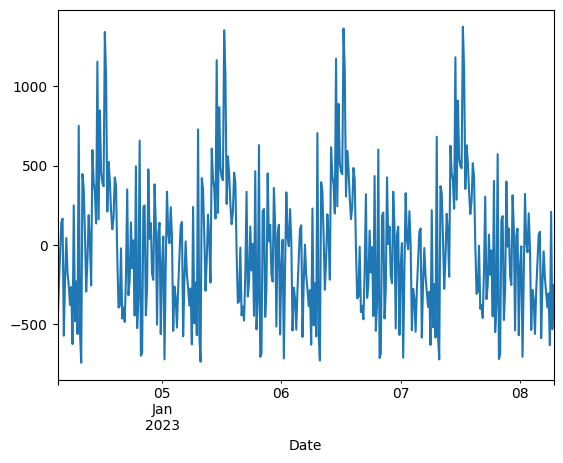

In [63]:
stlr.seasonal.iloc[300:700].plot()

<Axes: xlabel='Date'>

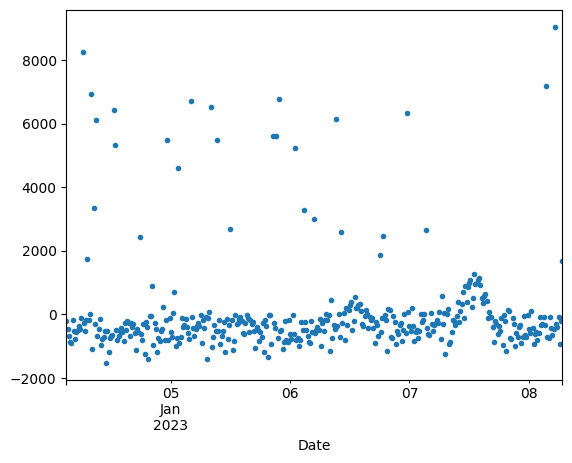

In [64]:
stlr.resid.iloc[300:700].plot(style='.')

<Axes: xlabel='Date'>

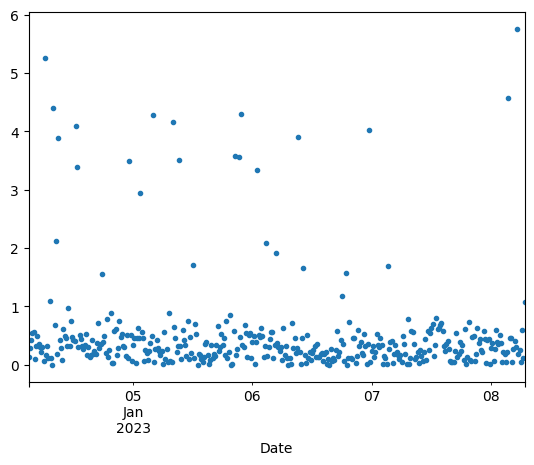

In [65]:
dgx['Z-Score'].iloc[300:700].plot(style='.')

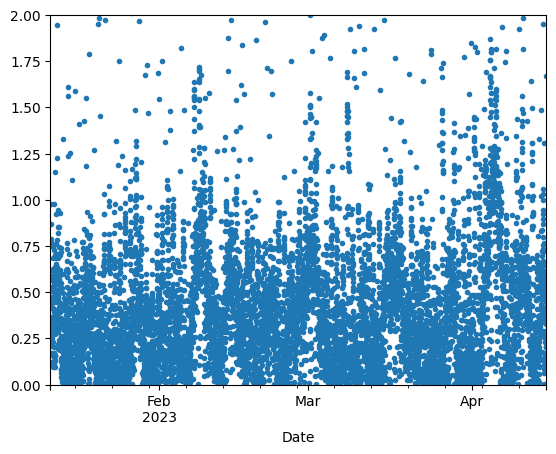

In [66]:
try:
    ax = dgx['Z-Score'].iloc[1000:10000].plot(style='.')
    ax.set_ylim(0,2)
except:
    print('wrong x interval')

In [67]:
stlr.resid

Date
2023-01-01 00:00:00    -531.878598
2023-01-01 00:15:00    -793.541220
2023-01-01 00:30:00      84.410429
2023-01-01 00:45:00    -594.123122
2023-01-01 01:00:00   -1008.874123
                          ...     
2023-12-31 22:45:00    -813.922888
2023-12-31 23:00:00    -659.246382
2023-12-31 23:15:00    -116.301935
2023-12-31 23:30:00    -276.527171
2023-12-31 23:45:00    -265.801532
Freq: 15min, Name: resid, Length: 35040, dtype: float64

## STL + LOF

Outlier nicht via Zscore, sondern via LOF (hier besser geeignet als HDBSCAN)

In [68]:
#Find outliers via LOF

if choose_noisy:
    autoscale = (dgn.iloc[:,3] - dgn.iloc[:,3].shift(1)).abs().sum() / len(dgn)
else:
    autoscale = (dgn.iloc[:,1] - dgn.iloc[:,1].shift(1)).abs().sum() / len(dgn)

scaling, nn, cont = 0.3 * autoscale, 6, 'auto'

# fine tuning:
#scaling, nn, cont = 0.3 * autoscale, 7, 0.085 #'auto' 

X = dgn.iloc[:,[1,5]].copy()
X.iloc[:,0] = stlr.resid 
X.head(2)

,so,indx
Date,,
2023-01-01 00:00:00,-531.878598,0
2023-01-01 00:15:00,-793.541220,1


In [69]:
#sc_x = StandardScaler().set_output(transform="pandas")
#X = sc_x.fit_transform(X)

X.iloc[:,0] = X.iloc[:,0]/scaling

In [70]:
clfr = LocalOutlierFactor(n_neighbors=nn, contamination=cont)  # 16 / 15

In [71]:
y_predr = clfr.fit_predict(X)
X_scoresr = clfr.negative_outlier_factor_

In [72]:
dgn6 = dgn5.copy()
dgn6['hdbl'] = y_predr

In [73]:
print(check(dgn6))

Result: Outliers 3504, tp, fp: (2524, 0) in percent: 72, 0 %


In [74]:
scaling

np.float64(256.5659116749502)

In [75]:
protocol.append('\nSTL + LOF\n')
protocol.append(f'{scaling}, {scaling/autoscale}, {nn}, {cont}: ')
protocol.append(check(dgn6))

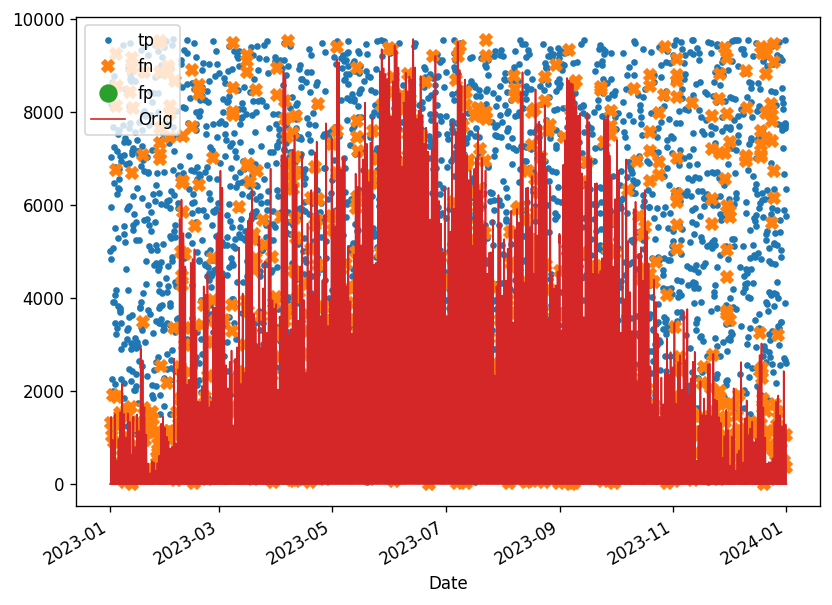

In [76]:
plotresult(dgn6)

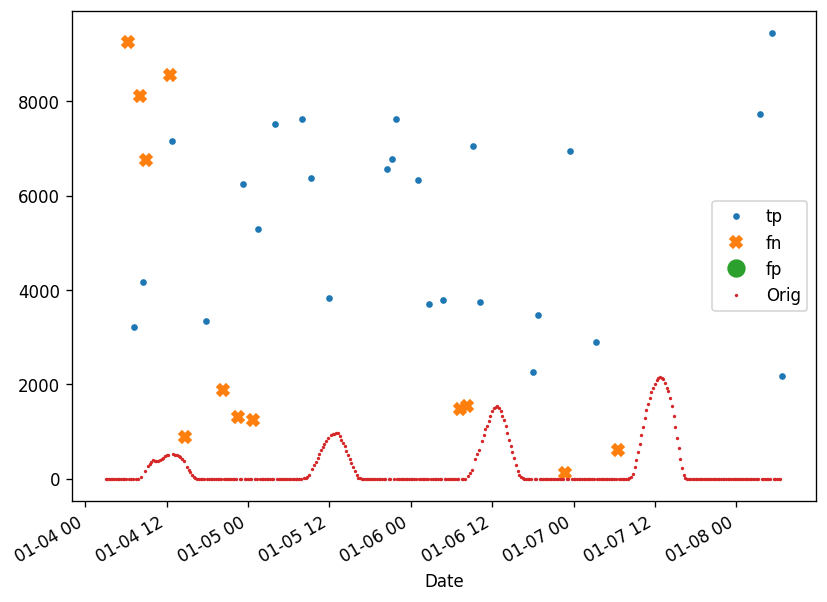

In [77]:
plotresult(dgn6.iloc[300:700,:])

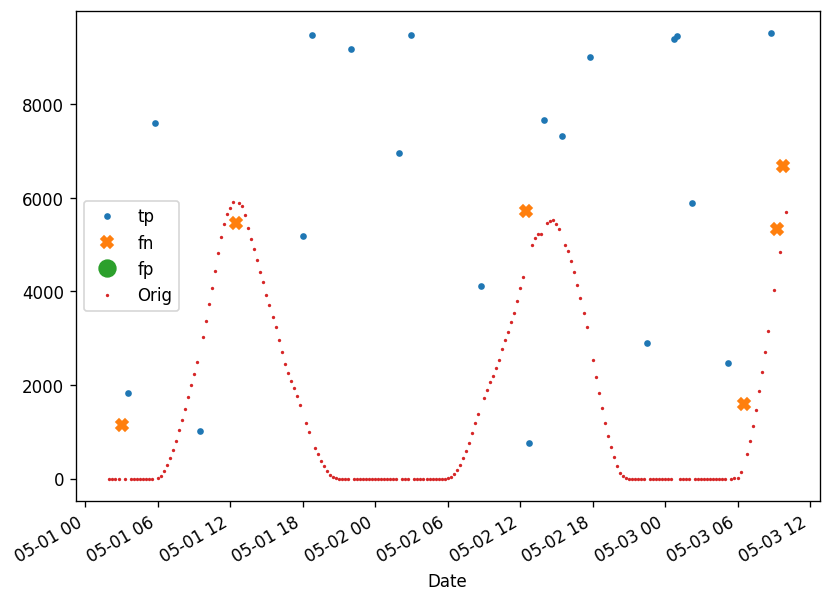

In [78]:
try:
    plotresult(dgn6.loc["2023-05-01 02:00":"2023-05-03 10:00",:])
except:
    print('wrong x interval')

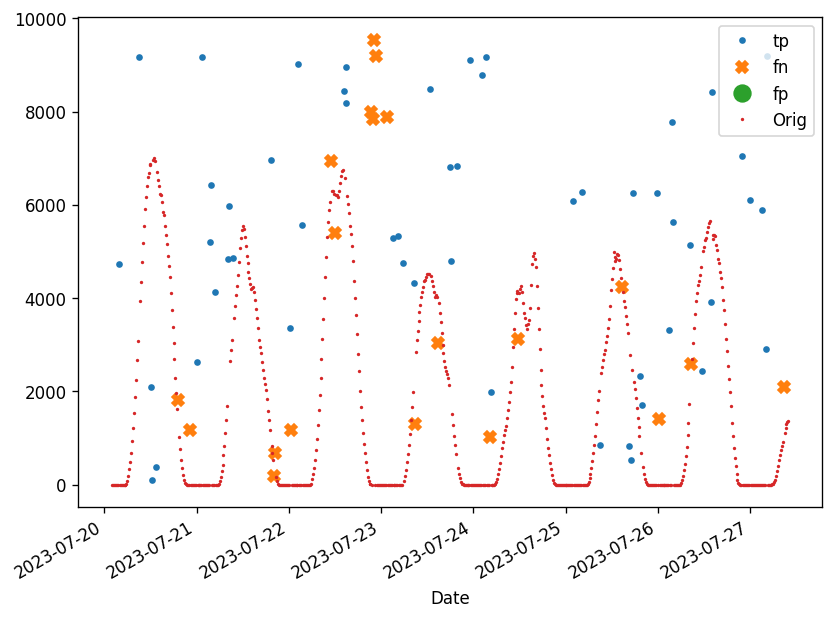

In [79]:
try:
    plotresult(dgn6.loc["2023-07-20 02:00":"2023-07-27 10:00",:])
except:
    print('wrong time interval')

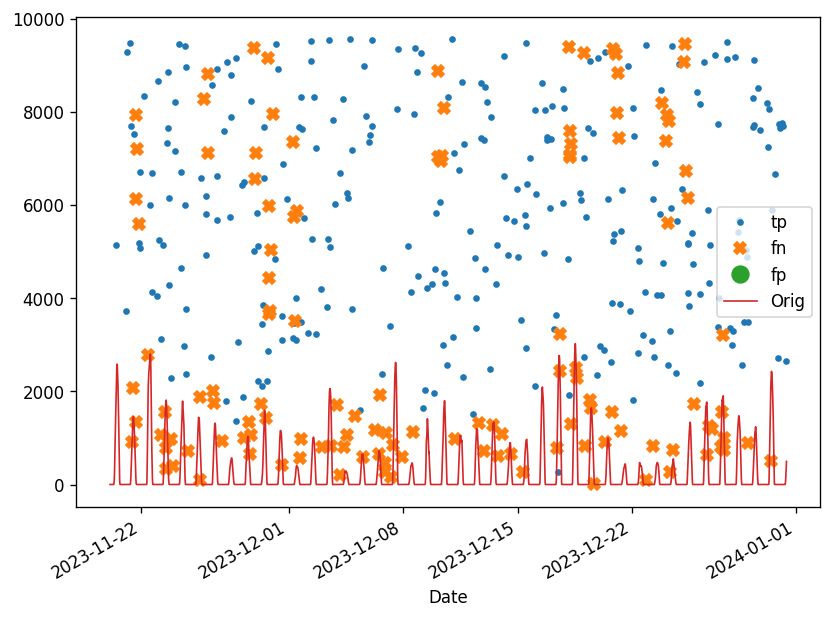

In [80]:
try:
    plotresult(dgn6.loc["2023-11-20 02:00":"2023-12-31 10:00",:])
except:
    print('wrong time interval')

## STL + LOF 

Optimiert für Datensatz 'fullyear'


In [81]:
#Find outliers via LOF

if choose_noisy:
    autoscale = (dgn.iloc[:,3] - dgn.iloc[:,3].shift(1)).abs().sum() / len(dgn)
else:
    autoscale = (dgn.iloc[:,1] - dgn.iloc[:,1].shift(1)).abs().sum() / len(dgn)

#scaling, nn, cont = 0.3 * autoscale, 6, 'auto'

# tweaking for 'fullyear'
scaling, nn, cont = 0.3 * autoscale, 7, 0.085 #'auto' 


X = dgn.iloc[:,[1,5]].copy()
X.iloc[:,0] = stlr.resid 
X.head(2)

,so,indx
Date,,
2023-01-01 00:00:00,-531.878598,0
2023-01-01 00:15:00,-793.541220,1


In [82]:
#sc_x = StandardScaler().set_output(transform="pandas")
#X = sc_x.fit_transform(X)

X.iloc[:,0] = X.iloc[:,0]/scaling

In [83]:
clfr = LocalOutlierFactor(n_neighbors=nn, contamination=cont)  # 16 / 15

In [84]:
y_predr = clfr.fit_predict(X)
X_scoresr = clfr.negative_outlier_factor_

In [85]:
dgn8 = dgn5.copy()
dgn8['hdbl'] = y_predr

In [86]:
print(check(dgn8))

Result: Outliers 3504, tp, fp: (2921, 58) in percent: 83, 1 %


In [87]:
scaling

np.float64(256.5659116749502)

In [88]:
protocol.append('\nSTL + LOF -- tweaking for "full year"\n')
protocol.append(f'{scaling}, {scaling/autoscale}, {nn}, {cont}: ')
protocol.append(check(dgn8))

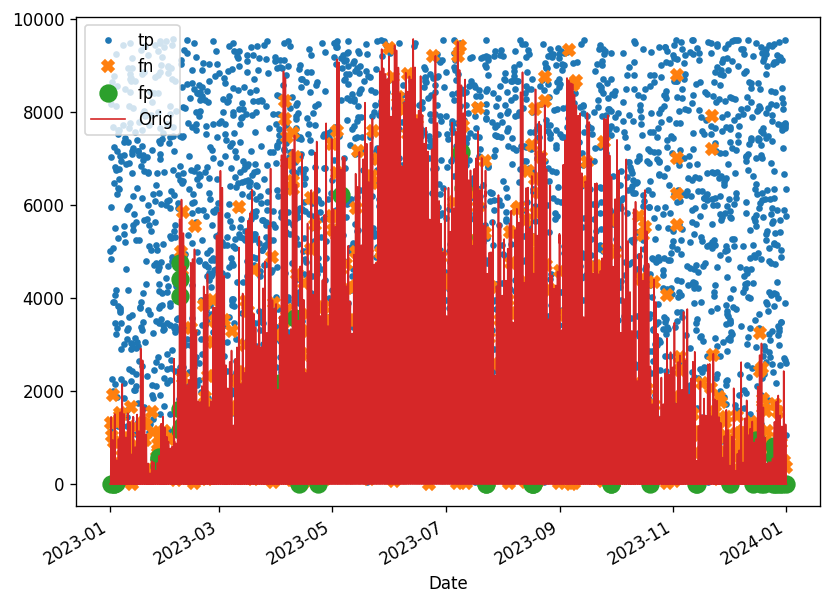

In [89]:
plotresult(dgn8)

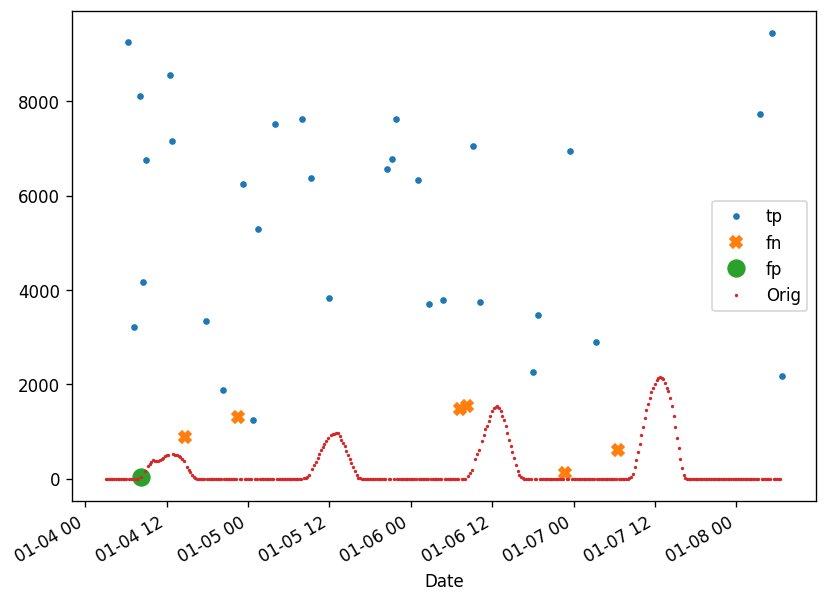

In [90]:
try:
    plotresult(dgn8.iloc[300:700,:])
except:
    print('wrong x interval')

Protokoll:

Die oberste Zeile nennt den Datensatz und den Anteil der Outliers (siehe *Artikel*, dort: 0.1 = 10%).

Verschiedene Verfahren schreiben ihre Ergebnisse in ein zweizeiliges Protokoll.

Die erste Zeile benennt das Verfahren und (rudimentär) Erläuterungen zu den Parametern (eg *HDBSCAN, scaling ...*), die zweite die Werte der Parameter und das Ergebnis (*Result*): *true positive* (ideal 100%), *false positive* (ideal: 0%).

*Falsch Positive* Werte ruinieren das Ergebnis. Würde man diesen Wert ignorieren, würde eine Zuordnung aller Daten zu *Ausreißern* mit einer Erkennungsrate von 100% die besten Ergebnisse liefern. 

In [91]:
print(''.join(protocol))

Data set: fullyear, Noisy: False, Outlier share: 0.1

HDBSCAN ; scaling, n * autoscale, mc, ms
855.2441132348008, 1.0, 70, 5: Result: Outliers 3504, tp, fp: (2214, 200) in percent: 63, 5 %
LOF
427.6098527915837, 0.5, 6,auto: Result: Outliers 3504, tp, fp: (2144, 0) in percent: 61, 0 %
Isolation Forest
855.2197055831674, 1.0, 30, auto: Result: Outliers 3504, tp, fp: (3018, 11988) in percent: 86, 342 %
STL , zscore
zscore 1.7248822976050735 Result: Outliers 3504, tp, fp: (2052, 8) in percent: 58, 0 %
STL + LOF
256.5659116749502, 0.3, 6, auto: Result: Outliers 3504, tp, fp: (2524, 0) in percent: 72, 0 %
STL + LOF -- tweaking for "full year"
256.5659116749502, 0.3, 7, 0.085: Result: Outliers 3504, tp, fp: (2921, 58) in percent: 83, 1 %
